## Object Detection - Inbuilt SSD model

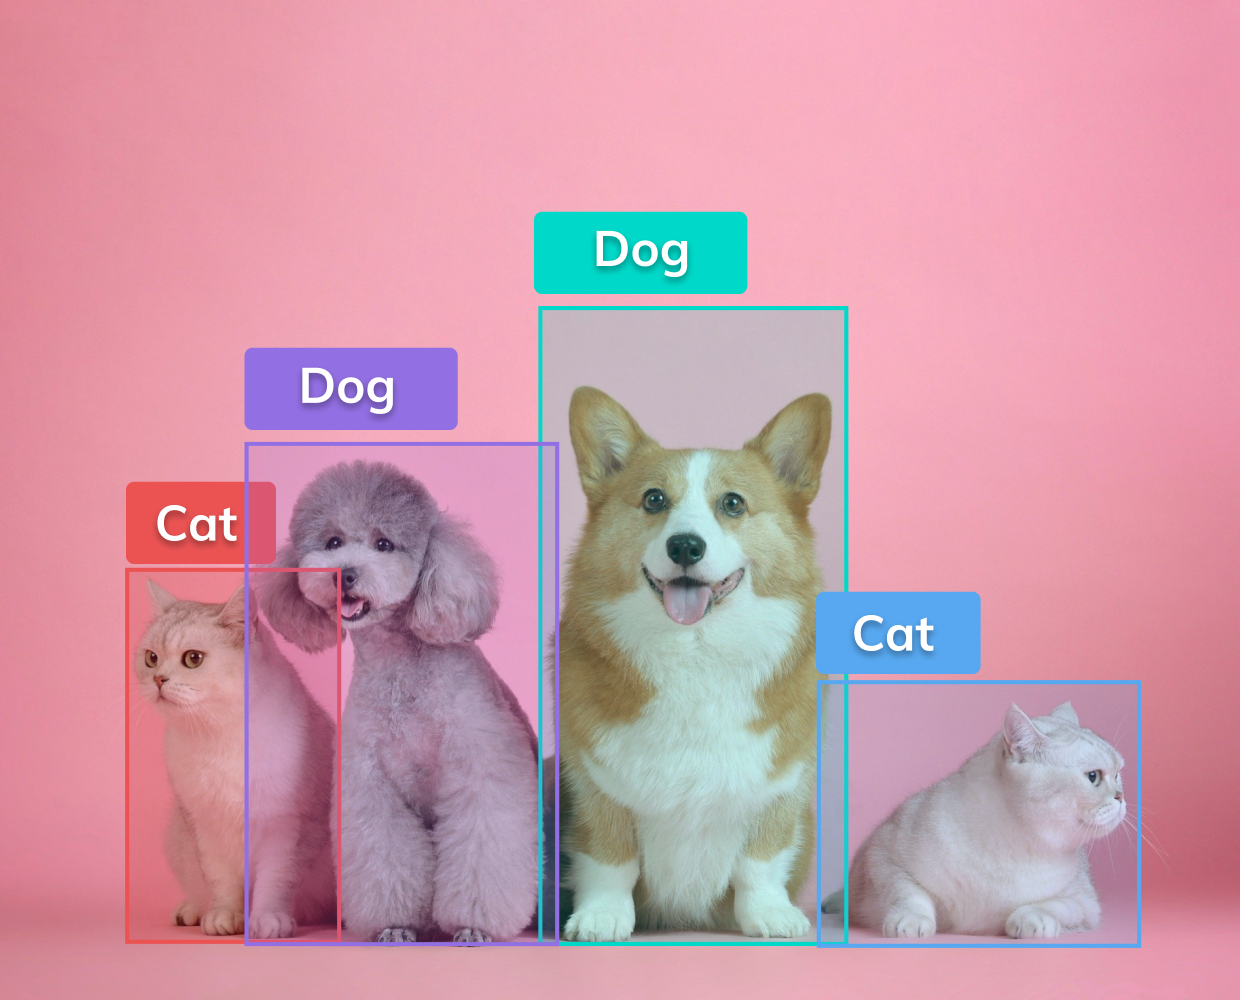

In [1]:
from IPython.display import Image
Image("https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/627d124572023b6948b6cdff_60ed9a4e09e2c648f1b8a013_object-detection-cover.png")

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
import json
import logging
from datetime import datetime

<IPython.core.display.Javascript object>

In [3]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

<IPython.core.display.Javascript object>

In [4]:
boto3.set_stream_logger(name="botocore.credentials", level=logging.WARNING)

<IPython.core.display.Javascript object>

In [5]:
sess = sagemaker.Session()
region = sess.boto_region_name
print(region)

ap-southeast-2


<IPython.core.display.Javascript object>

In [6]:
# role_arn = sagemaker.get_execution_role()
role_arn = os.getenv("SGMKR_ROLE_ARN")

<IPython.core.display.Javascript object>

In [7]:
bucket_name = "sgmkr-course"
data_path = "sgmkr_od_ssd"

nclasses = 3
nimgs_train = 36
nepochs = 10
mini_batch_size = 8

train_instance_type = "ml.g4dn.xlarge"
job_name_prefix = "flowers-od-ib-ssd-"

<IPython.core.display.Javascript object>

In [8]:
train_image_uri = sagemaker.image_uris.retrieve(
    framework="object-detection",
    region=region,
    image_scope="training",
    version="latest",
)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.
Ignoring unnecessary instance type: None.


<IPython.core.display.Javascript object>

In [9]:
s3_output_path = "s3://{}/{}/{}".format(bucket_name, data_path, "model_output")

<IPython.core.display.Javascript object>

In [10]:
od_estimator = sagemaker.estimator.Estimator(
    image_uri=train_image_uri,
    role=role_arn,
    instance_count=1,
    instance_type=train_instance_type,
    volume_size=50,
    max_run=360000,
    input_mode="File",
    output_path=s3_output_path,
    sagemaker_session=sess,
)

<IPython.core.display.Javascript object>

In [11]:
od_estimator.set_hyperparameters(
    num_classes=nclasses,  # update this
    num_training_samples=nimgs_train,  # update this
    epochs=nepochs,  # update this
    mini_batch_size=mini_batch_size,  # update this
    base_network="resnet-50",  # Transfer Learning
    use_pretrained_model=1,  # IMP
    learning_rate=0.002,
    lr_scheduler_step="10",
    lr_scheduler_factor=0.1,
    optimizer="sgd",
    momentum=0.9,
    weight_decay=0.0005,
    overlap_threshold=0.5,
    nms_threshold=0.45,
    image_shape=512,
    label_width=50,
)

<IPython.core.display.Javascript object>

In [12]:
s3_train_imgs = "s3://{}/{}/{}".format(bucket_name, data_path, "train_imgs")
s3_valid_imgs = "s3://{}/{}/{}".format(bucket_name, data_path, "valid_imgs")
s3_train_annot = "s3://{}/{}/{}".format(bucket_name, data_path, "train_annots")
s3_valid_annot = "s3://{}/{}/{}".format(bucket_name, data_path, "valid_annots")

train_imgs = sagemaker.inputs.TrainingInput(
    s3_train_imgs,
    distribution="FullyReplicated",
    content_type="image/jpeg",
    s3_data_type="S3Prefix",
)
valid_imgs = sagemaker.inputs.TrainingInput(
    s3_valid_imgs,
    distribution="FullyReplicated",
    content_type="image/jpeg",
    s3_data_type="S3Prefix",
)
train_annot = sagemaker.inputs.TrainingInput(
    s3_train_annot,
    distribution="FullyReplicated",
    content_type="image/jpeg",
    s3_data_type="S3Prefix",
)
valid_annot = sagemaker.inputs.TrainingInput(
    s3_valid_annot,
    distribution="FullyReplicated",
    content_type="image/jpeg",
    s3_data_type="S3Prefix",
)

data_channels = {
    "train": train_imgs,
    "validation": valid_imgs,
    "train_annotation": train_annot,
    "validation_annotation": valid_annot,
}

<IPython.core.display.Javascript object>

In [13]:
timestamp = (
    str(datetime.now().replace(microsecond=0)).replace(" ", "-").replace(":", "-")
)
job_name = job_name_prefix + timestamp
print(job_name)

flowers-od-ib-ssd-2023-03-21-16-57-56


<IPython.core.display.Javascript object>

In [14]:
od_estimator.fit(inputs=data_channels, logs=True, job_name=job_name)

Creating training-job with name: flowers-od-ib-ssd-2023-03-21-16-57-56


2023-03-21 05:57:57 Starting - Starting the training job...
2023-03-21 05:58:12 Starting - Preparing the instances for training...
2023-03-21 05:59:07 Downloading - Downloading input data...
2023-03-21 05:59:32 Training - Downloading the training image........
2023-03-21 06:00:42 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Tue Mar 21 06:00:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.07    Driver Version: 515.65.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               

[03/21/2023 06:01:09 INFO 140290042931008] #quality_metric: host=algo-1, epoch=0, batch=5 train cross_entropy <loss>=(1.7967604743109808)
[03/21/2023 06:01:09 INFO 140290042931008] #quality_metric: host=algo-1, epoch=0, batch=5 train smooth_l1 <loss>=(0.6630529544971607)
[03/21/2023 06:01:09 INFO 140290042931008] Round of batches complete
[03/21/2023 06:01:09 INFO 140290042931008] Updated the metrics
[03/21/2023 06:01:10 INFO 140290042931008] #quality_metric: host=algo-1, epoch=0, validation mAP <score>=(0.0006380252657059647)
[03/21/2023 06:01:10 INFO 140290042931008] Updating the best model with validation-mAP=0.0006380252657059647
[03/21/2023 06:01:10 INFO 140290042931008] Saved checkpoint to "/opt/ml/model/model_algo_1-0000.params"
[03/21/2023 06:01:10 INFO 140290042931008] #progress_metric: host=algo-1, completed 10.0 % of epochs
#metrics {"StartTime": 1679378463.3228939, "EndTime": 1679378470.4263215, "Dimensions": {"Algorithm": "AWS/Object Detection", "Host": "algo-1", "Operatio


2023-03-21 06:01:38 Uploading - Uploading generated training model[03/21/2023 06:01:30 INFO 140290042931008] #quality_metric: host=algo-1, epoch=9, validation mAP <score>=(0.028176501860712386)
[03/21/2023 06:01:30 INFO 140290042931008] #progress_metric: host=algo-1, completed 100.0 % of epochs
#metrics {"StartTime": 1679378488.5201957, "EndTime": 1679378490.3792412, "Dimensions": {"Algorithm": "AWS/Object Detection", "Host": "algo-1", "Operation": "training", "epoch": 9, "Meta": "training_data_iter"}, "Metrics": {"Total Records Seen": {"sum": 0.0, "count": 1, "min": 0, "max": 0}, "Total Batches Seen": {"sum": 0.0, "count": 1, "min": 0, "max": 0}, "Max Records Seen Between Resets": {"sum": 0.0, "count": 1, "min": 0, "max": 0}, "Max Batches Seen Between Resets": {"sum": 0.0, "count": 1, "min": 0, "max": 0}, "Reset Count": {"sum": 10.0, "count": 1, "min": 10, "max": 10}, "Number of Records Since Last Reset": {"sum": 0.0, "count": 1, "min": 0, "max": 0}, "Number of Batches Since Last Res

<IPython.core.display.Javascript object>

In [15]:
infer_instance_type = "ml.t2.medium"
model_name = job_name
endpoint_name = job_name

<IPython.core.display.Javascript object>

In [18]:
od_predictor = od_estimator.deploy(
    initial_instance_count=1,
    instance_type=infer_instance_type,
    endpoint_name=endpoint_name,
    model_name=model_name,
)

Creating model with name: flowers-od-ib-ssd-2023-03-21-16-57-56
Creating endpoint-config with name flowers-od-ib-ssd-2023-03-21-16-57-56
Creating endpoint with name flowers-od-ib-ssd-2023-03-21-16-57-56


----------------!

<IPython.core.display.Javascript object>

In [19]:
sgmkr_runt = boto3.client("runtime.sagemaker")

<IPython.core.display.Javascript object>

In [23]:
with open("images/rose.jpg", "rb") as image:
        payload = image.read()
        payload = bytearray(payload)
        
response = sgmkr_runt.invoke_endpoint(
    EndpointName = endpoint_name,
    ContentType = 'image/jpeg',
    #Accept = "application/json;n_predictions=5",
    Body = payload,
)

prediction = json.loads(response['Body'].read().decode())
print(prediction)


{'prediction': [[0.0, 0.3848296105861664, 0.2949581444263458, 0.4293615221977234, 0.42599937319755554, 0.5943439602851868], [0.0, 0.381910115480423, 0.6468297243118286, 0.2760745882987976, 0.7615469694137573, 0.430669903755188], [1.0, 0.38041630387306213, 0.9254640340805054, 0.0, 1.0, 0.061581552028656006], [1.0, 0.375691294670105, 0.46112871170043945, 0.586995005607605, 0.5657875537872314, 0.6949728727340698], [1.0, 0.37286534905433655, 0.0, 0.9329835772514343, 0.06630755215883255, 1.0], [0.0, 0.3715086877346039, 0.2585042715072632, 0.3743842840194702, 0.3884844183921814, 0.5269457697868347], [1.0, 0.370464026927948, 0.7440735101699829, 0.8314143419265747, 0.8441121578216553, 0.9467120170593262], [0.0, 0.36671918630599976, 0.7399877905845642, 0.5010684132575989, 0.859707772731781, 0.6520853638648987], [0.0, 0.3629227578639984, 0.7043559551239014, 0.3450604975223541, 0.8305513858795166, 0.49466416239738464], [0.0, 0.35716646909713745, 0.2660175561904907, 0.15249350666999817, 0.38412016

<IPython.core.display.Javascript object>

In [24]:
od_predictor.delete_endpoint()

Deleting endpoint configuration with name: flowers-od-ib-ssd-2023-03-21-16-57-56
Deleting endpoint with name: flowers-od-ib-ssd-2023-03-21-16-57-56


<IPython.core.display.Javascript object>